In [5]:
import torch
import pandas as pd
import requests
from PIL import Image
import cv2 # This is OpenCV
import numpy as np
from ultralytics import YOLO
import os

# Display images right in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [7]:
pip install dill

     |████████████████████████████████| 119 kB 8.7 MB/s eta 0:00:01
You should consider upgrading via the '/Users/ravinder/Desktop/flickd-hackathon/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
# This is the magic snippet for your M1 Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("MPS not found, using CPU")

# Define path to the model
MODEL_PATH = '../models/best.pt'

# Load the YOLOv8 model
# The model file is loaded onto the CPU first
model = YOLO(MODEL_PATH)

# Move the model to the correct device (GPU or CPU)
model.to(device)

print(f"YOLOv8 model loaded from {MODEL_PATH} and moved to {device}.")

Using MPS (Apple Silicon GPU)
YOLOv8 model loaded from ../models/best.pt and moved to mps.


Testing with Product ID: 15095
Title: Alexa|Trucotton V-Neck Sleeveless Boxy Top
Image URL: https://cdn.shopify.com/s/files/1/0785/1674/8585/files/13thNOV2024Virgio-0024_512x.jpg?v=1734526383
Image downloaded successfully.


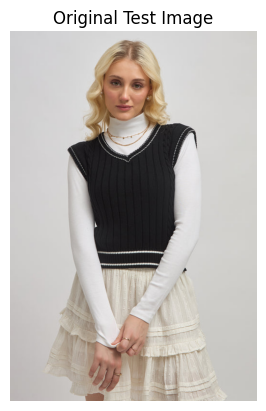

In [39]:
CATALOG_PATH = '../data/catalog_full.csv'
df_catalog = pd.read_csv(CATALOG_PATH)

# Let's pick a random product to test. You can change the index number.
test_product_index = 700 
test_product = df_catalog.iloc[test_product_index]

image_url = test_product['image_url']
product_id = test_product['id']
product_title = test_product['title']

print(f"Testing with Product ID: {product_id}")
print(f"Title: {product_title}")
print(f"Image URL: {image_url}")

# Download the image from the URL
try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status() # Raise an exception for bad status codes
    # Open the image using Pillow (PIL)
    test_image = Image.open(response.raw).convert("RGB")
    print("Image downloaded successfully.")
    
    # Display the original image
    plt.imshow(test_image)
    plt.title("Original Test Image")
    plt.axis('off') # Hide axes
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [40]:
# Cell 4: Run the YOLOv8 model on the image
if 'test_image' in locals():
    # The model expects the image as an argument
    # We can pass the PIL image directly
    results = model(test_image)
    print("Model inference complete.")
else:
    print("Skipping inference because image failed to download.")


0: 640x448 1 shirt, 1632.9ms
Speed: 36.9ms preprocess, 1632.9ms inference, 81.1ms postprocess per image at shape (1, 3, 640, 448)
Model inference complete.


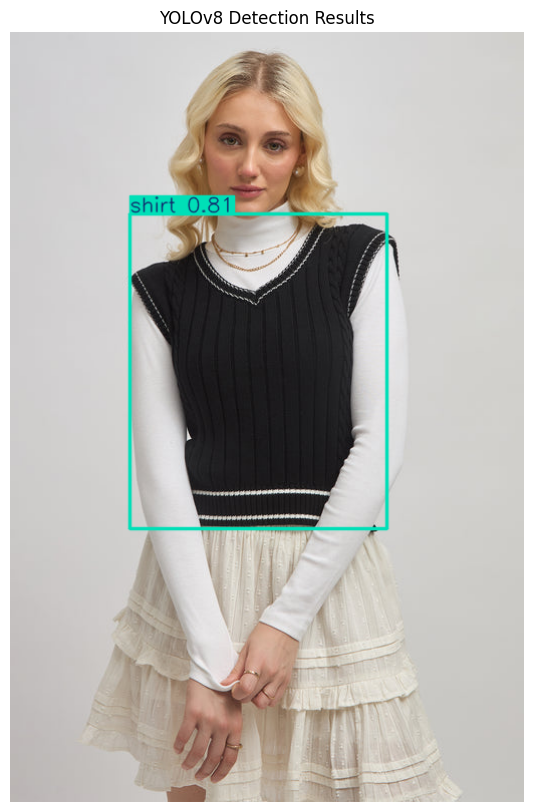


Detected objects:
- Class: shirt, Confidence: 0.81, Coords: [     247.41      338.83      255.89      314.24]


In [41]:
if 'results' in locals():
    # The results object contains all the detections.
    # We can use its built-in plot() method to draw the boxes!
    
    # The plot() method returns a NumPy array of the image with boxes drawn on it
    annotated_image_np = results[0].plot()

    # Convert the NumPy array (in BGR format from OpenCV) to RGB for display
    annotated_image_rgb = cv2.cvtColor(annotated_image_np, cv2.COLOR_BGR2RGB)
    
    # Display the image with detections
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image_rgb)
    plt.title("YOLOv8 Detection Results")
    plt.axis('off')
    plt.show()

    # You can also inspect the boxes programmatically
    print("\nDetected objects:")
    for box in results[0].boxes:
        class_name = model.names[int(box.cls)]
        confidence = float(box.conf)
        coords = box.xywh.cpu().numpy()[0] # (x_center, y_center, width, height)
        print(f"- Class: {class_name}, Confidence: {confidence:.2f}, Coords: {coords}")